# 6章 学習に関するテクニック

最適な重みパラメータを探索する最適化手 法、重みパラメータの初期値、ハイパーパラメータの設定方法など、どれもがニュー ラルネットワークの学習において重要なテーマです。また、過学習の対応策として、 Weight decay や Dropout などの正則化手法について概要を説明し、その実装を行 います。最後に、近年多くの研究で使用される Batch Normalization という手法に ついても簡単な説明を行います。本章で述べる手法を用いることで、ニューラルネッ トワーク(ディープラーニング)の学習を効率的に進めることができ、認識精度を高 めることができます。

In [1]:
import numpy as np

## 6.1 パラメータの更新
ニューラルネットワークの学習の目的は、損失関数の値をできるだけ小さくするパ ラメータを見つけることです。これは最適なパラメータを見つける問題であり、その ような問題を解くことを最適化(optimization)と言います。

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

ここで、初期化の際の引数である lr は learning rate(学習係数)を表 します。この学習係数は、インスタンス変数として保持されます。また、 update(params, grads) というメソッドを定義しますが、SGD では、このメソッ ドが繰り返し呼ばれることになります。引数の params と grads は、(これまでの ニューラルネットワークの実装と同じく)ディクショナリ変数です。params['W1']、 grads['W1'] などのように、それぞれに重みパラメータと勾配が格納されています。

### 6.1.3 SGD の欠点
SGD の非効率な探索経路の根本的な原因は、勾配の方向が本来の最小値では ない方向を指していることに起因します。

### 6.1.4 Momentum

In [2]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

### 6.1.5 AdaGrad
ニューラルネットワークの学習では、学習係数――数式では η で表記――の値が重 要になります。学習係数が小さすぎると学習に時間がかかりすぎてしまい、逆に大き すぎると発散して正しい学習が行えません。<br>
この学習係数に関する有効なテクニックとして、学習係数の減衰(learning rate decay)という方法があります。これは、学習が進むにつれて学習係数を小さくする という方法です。最初は“大きく”学習し、次第に“小さく”学習するという手法で、 ニューラルネットワークの学習では実際によく使われます。<br>
学習係数を徐々に下げていくというアイデアは、パラメータ「全体」の学習係数の 値を一括して下げることに相当します。これをさらに発展させたのが AdaGrad [6] です。AdaGrad は、「一つひとつ」のパラメータに対して、“オーダーメイド”の値 をこしらえます。<br>
AdaGrad は、パラメータの要素ごとに適応的に学習係数を調整しながら学習を行 う手法です(AdaGrad の Ada は「適応的」を意味する Adaptive に由来します)。 それでは、AdaGrad の更新方法を数式で表します。

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.6 Adam
Adam は 2015 年に提案された新しい手法です。その理論はやや複雑ですが、直 感的には、Momentum と AdaGrad を融合したような手法です。<br>
先の 2 つの手法 の利点を組み合わせることで、効率的にパラメータ空間を探索することが期待でき ます。また、ハイパーパラメータの「バイアス補正(偏りの補正)」が行われてい ることも Adam の特徴です。

## 6.2 重みの初期値
過学習を抑え、汎化性能を高めるテクニックとして、この後、Weight decay(荷重 減衰)という手法を紹介します。Weight decay とは、簡単に言えば、重みパラメー タの値が小さくなるように学習を行うことを目的とした手法です。重みの値を小さく することで、過学習が起きにくくなります。<br>
重みの値を小さくしたいというのであれば、重みの初期値をすべて 0 に設定する、 というのはどうでしょうか? 答えを先に言ってしまうと、重みの初期値を 0 にするというのは悪いアイデアです。実際、重みの初期値を 0 にすると、正しい学習が行えません。<br>
なぜ重みの初期値を 0 にしてはいけない――正確には、重みを均一な値に設定して はいけない――のでしょうか? それは誤差逆伝播法において、すべての重みの値が 均一に(同じように)更新されてしまうからです。たとえば、2 層のニューラルネッ トワークにおいて、1 層目と 2 層目の重みが 0 だと仮定します。そうすると、順伝 播時には、入力層の重みが 0 であるため、2 層目のニューロンにはすべて同じ値が伝 達されます。2 層目のニューロンですべて同じ値が入力されるということは、逆伝播 のときに 2 層目の重みはすべて同じように更新されるということになります(「乗算 ノードの逆伝播」を思い出しましょう)。そのため、均一の値で更新され、重みは対 称的な値(重複した値)を持つようになってしまうのです。これでは、たくさんの重 みを持つ意味がなくなってしまいます。この「重みが均一になってしまうこと」を防 ぐ――正確には、重みの対称的な構造を崩す――ために、ランダムな初期値が必要な のです。

### 6.2.2 隠れ層のアクティベーション分布
隠れ層のアクティベーション†2(活性化関数の後の出力データ)の分布を観察する ことで多くの知見が得られます。ここでは、重みの初期値によって隠れ層のアクティ ベーションがどのように変化するか、簡単な実験を行ってみようと思います

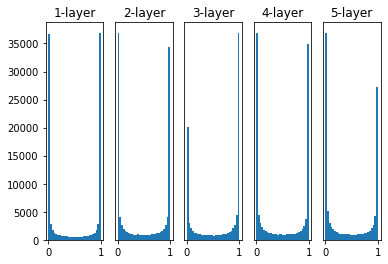

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


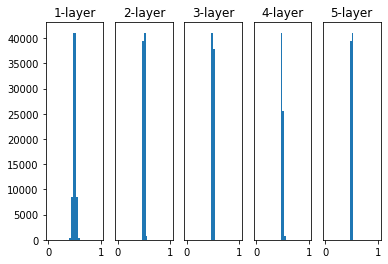

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


先ほどの例のように 0 と 1 への偏 りはないので、勾配消失の問題は起きません。しかし、アクティベーションに偏りが あるということは、表現力の点で大きな問題があります。なぜなら、複数のニューロ ンがほとんど同じ値を出力するとすれば、複数のニューロンが存在する意味がなく なってしまうからです。たとえば、100 個のニューロンがほぼ同じ値を出力するとす れば、それは 1 個のニューロンでもほぼ同じことを表現することができます。そのた め、アクティベーションの偏りは、「表現力の制限」の点で問題になります。

### Xavier の初期値

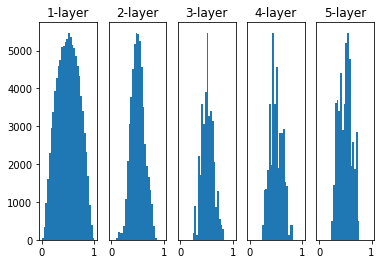

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


### 6.2.3 ReLU の場合の重みの初期値
ReLU を用いる場合は、ReLU に特化し
た初期値を用いることが推奨されています。それは、Kaiming He らが推奨する初期
値――その名も「He の初期値」[10] です。

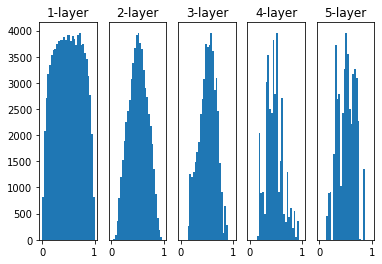

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


## 6.3 Batch Normalization
前節の「6.2 重みの初期値」では、各層のアクティベーションの分布を観察しまし た。そこで学んだことは、重みの初期値を適切に設定すれば、各層のアクティベー ションの分布は適度な広がりを持ち、学習がスムーズに行えるということでした。<br>
そ れでは、各層で適度な広がりを持つように、“強制的”にアクティベーションの分布 を調整してみてはどうでしょうか? 実は、そのようなアイデアをベースとする手法 が Batch Normalization [11] なのです。

なぜこれほど Batch Norm が注目されているかというと、Batch Norm には次の 利点があるからです。<br>
● 学習を速く進行させることができる(学習係数を大きくすることができる)<br>
● 初期値にそれほど依存しない(初期値に対してそこまで神経質にならなくてよい)<br>
● 過学習を抑制する(Dropout などの必要性を減らす)<br>

## 6.4 正則化

### 6.4.1 過学習
過学習が起きる原因として、主に次の 2 つが挙げられます。<br>
● パラメータを大量に持ち、表現力の高いモデルであること<br>
● 訓練データが少ないこと<br>

### 6.4.2 Weight decay
学習の過程において、大きな重みを持つことに対してペ ナルティを課すことで、過学習を抑制しようというものです。そもそも過学習は、重 みパラメータが大きな値を取ることによって発生することが多くあるのです。<br>
重みの 2 乗ノルム(L2 ノ ルム)を損失関数に加算します。そうすれば、重みが大きくなることを抑えることが できそうです。記号で表すと、重みを W とすれば、L2 ノルムの Weight decay は、
21 λW2 になり、この 21 λW2 を損失関数に加算します。ここで、λ は正則化の強さを コントロールするハイパーパラメータです。λ を大きく設定すればするほど、大きな 重みを取ることに対して強いペナルティを課すことになります。また、21λW2 の先 頭の 21 は、 12 λW2 の微分の結果を λW にするための調整用の定数です。

### 6.4.3 Dropout
過学習を抑制する手法として、損失関数に対して重みの L2 ノルムを加算する Weight decay という手法を説明しました。Weight decay は簡単に実装でき、ある 程度過学習を抑制することができます。しかし、ニューラルネットワークのモデルが 複雑になってくると、Weight decay だけでは対応が困難になってきます。そこで、 Dropout [14] という手法がよく用いられます。<br>
Dropout は、ニューロンをランダムに消去しながら学習する手法です。訓練時に 隠れ層のニューロンをランダムに選び出し、その選び出したニューロンを消去しま す。<br>
消去されたニューロンは、図6-22 に示すように、信号の伝達が行われなくなり ます。なお、訓練時には、データが流れるたびに、消去するニューロンをランダムに 選択します。そして、テスト時には、すべてのニューロンの信号を伝達しますが、各 ニューロンの出力に対して、訓練時に消去した割合を乗算して出力します。

In [1]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask

        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

ここでのポイントは、順伝播のたびに、self.mask に消去するニューロンを False として格納するということです。self.mask は、x と同じ形状の配列をランダムに 生成し、その値が dropout_ratio よりも大きい要素だけを True とします。逆伝播 の際の挙動は ReLU と同じです。つまり、順伝播で信号を通したニューロンは、逆 伝播の際に伝わる信号をそのまま通し、順伝播で信号を通さなかったニューロンは、 逆伝播では信号がそこでストップします。

## 6.5 ハイパーパラメータの検証
ここで言うハイパーパラ メータとは、たとえば、各層のニューロンの数やバッチサイズ、パラメータの更新の際の学習係数や Weight decay などです。そのようなハイパーパラメータは、適切な 値に設定しなければ、性能の悪いモデルになってしまいます。ハイパーパラメータの 値はとても重要ですが、ハイパーパラメータの決定には一般に多くの試行錯誤が伴い ます。ここでは、できるだけ効率的にハイパーパラメータの値を探索する方法につい て説明します。

### 6.5.1 検証データ
これまで使用したデータセットは、訓練データとテストデータの 2 つに分離して利 用してきました。訓練データで学習を行い、テストデータを使って汎化性能を評価す る――そうすることで、訓練データだけに過度に適応しすぎていないか(過学習を起 こしていないか)、そして、汎化性能はどれくらいか、ということを評価することが できたのです。<br>
これからハイパーパラメータをさまざまな値に設定して検証していきますが、ここ
で注意すべき点は、テストデータを使ってハイパーパラメータの性能を評価してはい
けない、ということです。これは非常に大切ですが、見落としがちなポイントです。<br>
なぜ、テストデータを使ってハイパーパラメータの性能を評価してはいけないので しょうか? それは、テストデータを使ってハイパーパラメータを調整するとすれば、 ハイパーパラメータの値はテストデータに対して過学習を起こすことになるからで す。言い換えると、ハイパーパラメータの値の「良さ」をテストデータを使って確認 することになるので、テストデータだけに適合するようにハイパーパラメータの値が 調整されてしまいます。そうなると、他のデータには適応できない汎化性能の低いモ デルになってしまうかもしれません。
そのため、ハイパーパラメータを調整する際には、ハイパーパラメータ専用の確認 データが必要になります。ハイパーパラメータの調整用のデータは、一般に検証デー タ(validation data)と呼びます。この検証データを使って、ハイパーパラメータの 良さを評価します。

In [5]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

def shuffle_dataset(x, t):
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

(x_train, t_train), (x_test, t_test) = load_mnist()

x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.2
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]